In [1]:
import os
import json
import torch

from PIL import Image
from tqdm import tqdm
from torchvision import transforms
from diffusers import StableDiffusionImg2ImgPipeline, AutoPipelineForImage2Image
from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig

/home/r12942159/miniconda3/envs/AI/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def read_images(img_dir):
    img_paths = [os.path.join(img_dir, f"{str(i).zfill(6)}.jpg") for i in range(1, 101)]
    images = [Image.open(path) for path in img_paths]

    return images

In [3]:
def load_phi4_model(phi4_model_name, custom_cache_dir):
    processor = AutoProcessor.from_pretrained(phi4_model_name, trust_remote_code=True, cache_dir=custom_cache_dir)
    model = AutoModelForCausalLM.from_pretrained(
        phi4_model_name, 
        device_map="cuda", 
        torch_dtype="auto", 
        trust_remote_code=True,
        _attn_implementation='flash_attention_2',
        cache_dir=custom_cache_dir,
    ).cuda()

    return processor, model

In [4]:
def generate_text_prompt(image, processor, model, phi4_model_name):
    instruction = "<|user|><|image_1|>Describe this person in the exact artistic style of Peanuts comics (Snoopy-style). Ensure the description makes the character look like they belong in a Charles Schulz comic strip. The person’s features—such as hair color, expression, and outfit—should remain the same, but they must be transformed into the signature Peanuts cartoon style: simple, bold outlines, flat colors, round heads, dot eyes, and minimal shading. The background should be minimalistic, similar to classic Peanuts comic settings. <|end|><|assistant|>"
    generation_config = GenerationConfig.from_pretrained(phi4_model_name)
    inputs = processor(text=instruction, images=image, return_tensors='pt').to('cuda:0')

    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=512,
            generation_config=generation_config,
        )
        generated_ids = generated_ids[:, inputs['input_ids'].shape[1]:]
        prompt = processor.batch_decode(generated_ids, 
                                        skip_special_tokens=True,
                                        clean_up_tokenization_spaces=False,)
    
    return prompt

In [17]:
def generate_text_prompts(images, length, processor, model):
    prompts = []
    for i in tqdm(range(length)):
        prompt = generate_text_prompt(
            images[i], 
            processor, 
            model, 
            "microsoft/Phi-4-multimodal-instruct"
        )
        prompts.append(prompt)
    
    return prompts

In [ ]:
def save_prompts2json(prompts, filename):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump({"prompts": prompts}, f, indent=4)
    
    print(f"Prompts successfully saved to {filename}")

In [ ]:
def load_stable_diffusion(model_id, cache_dir):
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
        model_id, 
        torch_dtype=torch.float16,
        cache_dir=cache_dir,
        safety_checker = None,
        feature_extractor = None,
    ).to("cuda")

    return pipe

In [3]:
def read_prompts(prompt_path):
    with open(prompt_path, "r", encoding="utf-8") as f:
        prompts = json.load(f)

    return prompts['prompts']

In [6]:
def resize_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    return transform(image).permute(1, 2, 0).mul(255).byte().numpy()

In [8]:
def generate_stylized_images(pipe, prompt, image, strength=0.75, guidance_scale=7.5, seed=41):
    image = Image.fromarray(resize_image(image))
    image = pipe(
        prompt=prompt, 
        image=image, 
        strength=strength, 
        guidance_scale=guidance_scale, 
        generator=torch.manual_seed(seed),
    ).images[0]

    
    return image

#### Main()

In [ ]:
phi4_processor, phi4_model = load_phi4_model(phi4_model_name = "microsoft/Phi-4-multimodal-instruct", 
                                             custom_cache_dir = "/home/r12942159/data_18TB")

images = read_images(img_dir = '/home/r12942159/NTU_AI/Hw1/content_image/')

prompts = generate_text_prompts(images, len(images), phi4_processor, phi4_model)
save_prompts2json(prompts, 'task2-2_prompts.json')

In [ ]:
pipe = load_stable_diffusion(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", 
    "/home/r12942159/data_18TB",
)

images = read_images(img_dir = '/home/r12942159/NTU_AI/Hw1/content_image/')
prompts = read_prompts("/home/r12942159/NTU_AI/Hw1/Task2-2_prompts.json")

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  9.55it/s]
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion_img2img.StableDiffusionImg2ImgPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['a simple , flat - colored shirt with minimal shading . the background would be minimalistic , with a few simple shapes to represent the setting .']
100%|██████████| 37/37 [00:01<00:00, 36.80it/s]


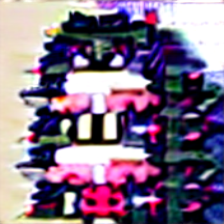

In [ ]:
generate_stylized_images(pipe, prompts[10], images[10], 0.75, 7.5, 97)

#### Generate profile photo with snoopy style

In [ ]:
phi4_processor, phi4_model = load_phi4_model(phi4_model_name = "microsoft/Phi-4-multimodal-instruct", 
                                             custom_cache_dir = "/home/r12942159/data_18TB")

img = Image.open('/home/r12942159/NTU_AI/Hw1/profile_photo.jpg')

instruction = "<|user|><|image_1|>Describe this person in the exact artistic style of Peanuts comics (Snoopy-style). Ensure the description makes the character look like they belong in a Charles Schulz comic strip. The person’s features—such as hair color, expression, and outfit—should remain the same, but they must be transformed into the signature Peanuts cartoon style: simple, bold outlines, flat colors, round heads, dot eyes, and minimal shading. The background should be minimalistic, similar to classic Peanuts comic settings. <|end|><|assistant|>"
generation_config = GenerationConfig.from_pretrained("microsoft/Phi-4-multimodal-instruct")
inputs = phi4_processor(text=instruction, images=img, return_tensors='pt').to('cuda:0')

with torch.no_grad():
    generated_ids = phi4_model.generate(
        **inputs,
        max_new_tokens=512,
        generation_config=generation_config,
    )
    generated_ids = generated_ids[:, inputs['input_ids'].shape[1]:]
    prompt = phi4_processor.batch_decode(generated_ids, 
                                    skip_special_tokens=True,
                                    clean_up_tokenization_spaces=False,)

In [33]:
img = Image.open('/home/r12942159/NTU_AI/Hw1/profile_photo.jpg')
prompt = 'In the Peanuts comic style, the person would have a round head with short, dark hair. The expression would be a simple, neutral look, with a slight hint of a smile. The outfit would be a white shirt with blue horizontal stripes, but the colors would be more solid and less detailed. The background would be minimalistic, with a plain white backdrop to keep the focus on the character. The overall style would be simple, bold, and cartoonish, fitting the Peanuts aesthetic.'
generate_stylized_images(pipe, prompt, img, 0.75, 10.5, 97).save('profile_snoopy.jpg')

FileNotFoundError: [Errno 2] No such file or directory: '/home/r12942159/NTU_AI/Hw1/profile_photo.jpg'